# Loading Task Data
---
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [ ]:
# @title Install dependencies
!pip install nilearn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.7 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds = Sampling rate

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['mental','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

## Downloading data
---

The task data are shared in different files, but they will unpack into the same directory structure.


In [ ]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

# urls = ["https://osf. io/bqp7m/download"
# "https://osf. io/s4h8j/download"
# "https://osf. io/x5p4g/download"
# "https://osf. io/j5kuc/download"

# "https://osf.io/s4h8i/download/"  Bati provided this

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [ ]:
#list of unique network name
unique_net = []

for net in region_info['network']:
  if net not in unique_net:
      unique_net.append(net)

print("there are ",len(unique_net),"unique networks.")
print(unique_net)

there are  12 unique networks.
['Visual1', 'Visual2', 'Somatomotor', 'Cingulo-Oper', 'Language', 'Default', 'Frontopariet', 'Auditory', 'Dorsal-atten', 'Posterior-Mu', 'Orbito-Affec', 'Ventral-Mult']


In [ ]:
#list of regions in each network
dict_reg_in_net = dict()
for net in unique_net:
  dict_reg_in_net[net] = [] #establish empty list associate with key 'str of network'
  for idx in range(len(region_info['name'])):
    current_brain_reg = region_info['name'][idx]
    if region_info['network'][idx] == net and (current_brain_reg not in dict_reg_in_net[net]):
      dict_reg_in_net[net].append(current_brain_reg)

for network,list_reg in dict_reg_in_net.items():
  print("Network name: ", network, "contains ", len(list_reg)," regions:")
  print(list_reg)

Network name:  Visual1 contains  6  regions:
['R_V1', 'R_ProS', 'R_DVT', 'L_V1', 'L_ProS', 'L_DVT']
Network name:  Visual2 contains  54  regions:
['R_MST', 'R_V6', 'R_V2', 'R_V3', 'R_V4', 'R_V8', 'R_V3A', 'R_V7', 'R_IPS1', 'R_FFC', 'R_V3B', 'R_LO1', 'R_LO2', 'R_PIT', 'R_MT', 'R_LIPv', 'R_VIP', 'R_PH', 'R_V6A', 'R_VMV1', 'R_VMV3', 'R_V4t', 'R_FST', 'R_V3CD', 'R_LO3', 'R_VMV2', 'R_VVC', 'L_MST', 'L_V6', 'L_V2', 'L_V3', 'L_V4', 'L_V8', 'L_V3A', 'L_V7', 'L_IPS1', 'L_FFC', 'L_V3B', 'L_LO1', 'L_LO2', 'L_PIT', 'L_MT', 'L_LIPv', 'L_VIP', 'L_PH', 'L_V6A', 'L_VMV1', 'L_VMV3', 'L_V4t', 'L_FST', 'L_V3CD', 'L_LO3', 'L_VMV2', 'L_VVC']
Network name:  Somatomotor contains  39  regions:
['R_4', 'R_3b', 'R_5m', 'R_5L', 'R_24dd', 'R_24dv', 'R_7AL', 'R_7PC', 'R_1', 'R_2', 'R_3a', 'R_6d', 'R_6mp', 'R_6v', 'R_OP4', 'R_OP1', 'R_OP2-3', 'R_FOP2', 'R_Ig', 'L_4', 'L_3b', 'L_5m', 'L_5L', 'L_24dd', 'L_24dv', 'L_7AL', 'L_7PC', 'L_1', 'L_2', 'L_3a', 'L_6d', 'L_6mp', 'L_6v', 'L_OP4', 'L_OP1', 'L_OP2-3', 'L_RI', 'L_F

### Examining the regions

In [ ]:
#examine the regions by myself
print(len(regions))
print(regions)
print(len(region_info['name']))
print(region_info.keys())
print(region_info['hemi'])

3
[['R_V1' 'R_MST' 'R_V6' ... 'L_PI' 'L_a32pr' 'L_p24']
 ['Visual1' 'Visual2' 'Visual2' ... 'Cingulo-Oper' 'Cingulo-Oper'
  'Cingulo-Oper']
 ['2.209' '2.05561' '2.1498' ... '1.74335' '1.73082' '1.65968']]
360
dict_keys(['name', 'network', 'hemi'])
['Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Rig

## Help functions
---

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task.

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [ ]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}") #ts is timeseries
  # print("this is ts",ts)
  # print("len(t)",len(ts))
  # print("ts.mean(axis=1, keepdims=True)", ts.mean(axis=1, keepdims=True))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    # print("ev_array",ev_array) ; basically just array of what's in txt file
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int) # this is start index for each frame
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int) # this is **how many** indices for that frame


    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

## Example run (EMOTION task)
---

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

In [ ]:
my_exp = 'EMOTION'
my_subj = subjects[0]
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)

(360, 176)


As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [ ]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)

#### Trying to understand evs (archived)
---

In [ ]:
print("frames of first cond:",evs[0])
print("frames of second cond: ",evs[1])
print(len(evs))

frames of first cond: [array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68]), array([103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]), array([161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185])]
frames of second cond:  [array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39]), array([73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97]), array([132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156])]
2


In [ ]:
idx = 0 # idx = 0 for 'fear' condition in 'EMOTION task' and idx = 1 for 'neut'
evs[idx]
for i in range(len(evs[idx])):
  print(evs[idx][i])




[44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 68]
[103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127]
[161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185]


In [ ]:
print(data.shape[1])

176


In [ ]:
# print(evs[0])
# print(data.shape[1])
idx = 0
frames_cond = evs[idx]
print("before removing",frames_cond)
for i, frame in enumerate(frames_cond):
  if frame[-1] > data.shape[1]: #if the time index in frame is larger than the datashape, exclude that frame
    print("index where it exceeds data frame: ",i)
    frames_cond = np.delete(frames_cond,i, axis=0)

print("after removing the elements",frames_cond)

before removing [array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68]), array([103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]), array([161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185])]
index where it exceeds data frame:  2
after removing the elements [[ 44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
   62  63  64  65  66  67  68]
 [103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
  121 122 123 124 125 126 127]]


In [ ]:
print(type(frames_cond[0]))

<class 'numpy.ndarray'>


For the motor task, this evs variable contains a list of 5 arrays corresponding to the 5 conditions.

Now let's use these evs to compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

##Back to the core code

In [ ]:
# we need a little function that averages all frames from any given condition

def average_frames(data,evs,experiment,cond):
  # get idx for the specific condition (ex. fear/neut)
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  # get rid of the index that exceed the dataframe
  frames_cond = evs[idx]
  for i, frame in enumerate(frames_cond):
    if frame[-1] > data.shape[1]: #if the time index in frame is larger than the datashape, exclude that frame
      frames_cond = np.delete(frames_cond,i, axis=0) #note the frams_cond is still np.array

  return np.mean(np.concatenate([np.mean(data[:, frames_cond[i]], axis=1, keepdims=True) for i in range(len(frames_cond))], axis=-1), axis=1)


fear_activity = average_frames(data, evs, my_exp, 'fear')
neut_activity = average_frames(data,evs, my_exp, 'neut')
contrast_emotion = fear_activity-neut_activity

#print(fear_activity)
#fear_activity = average_frames(data, evs, my_exp, 'fear')
#contrast = lf_activity - rf_activity  # difference between left and right hand movement

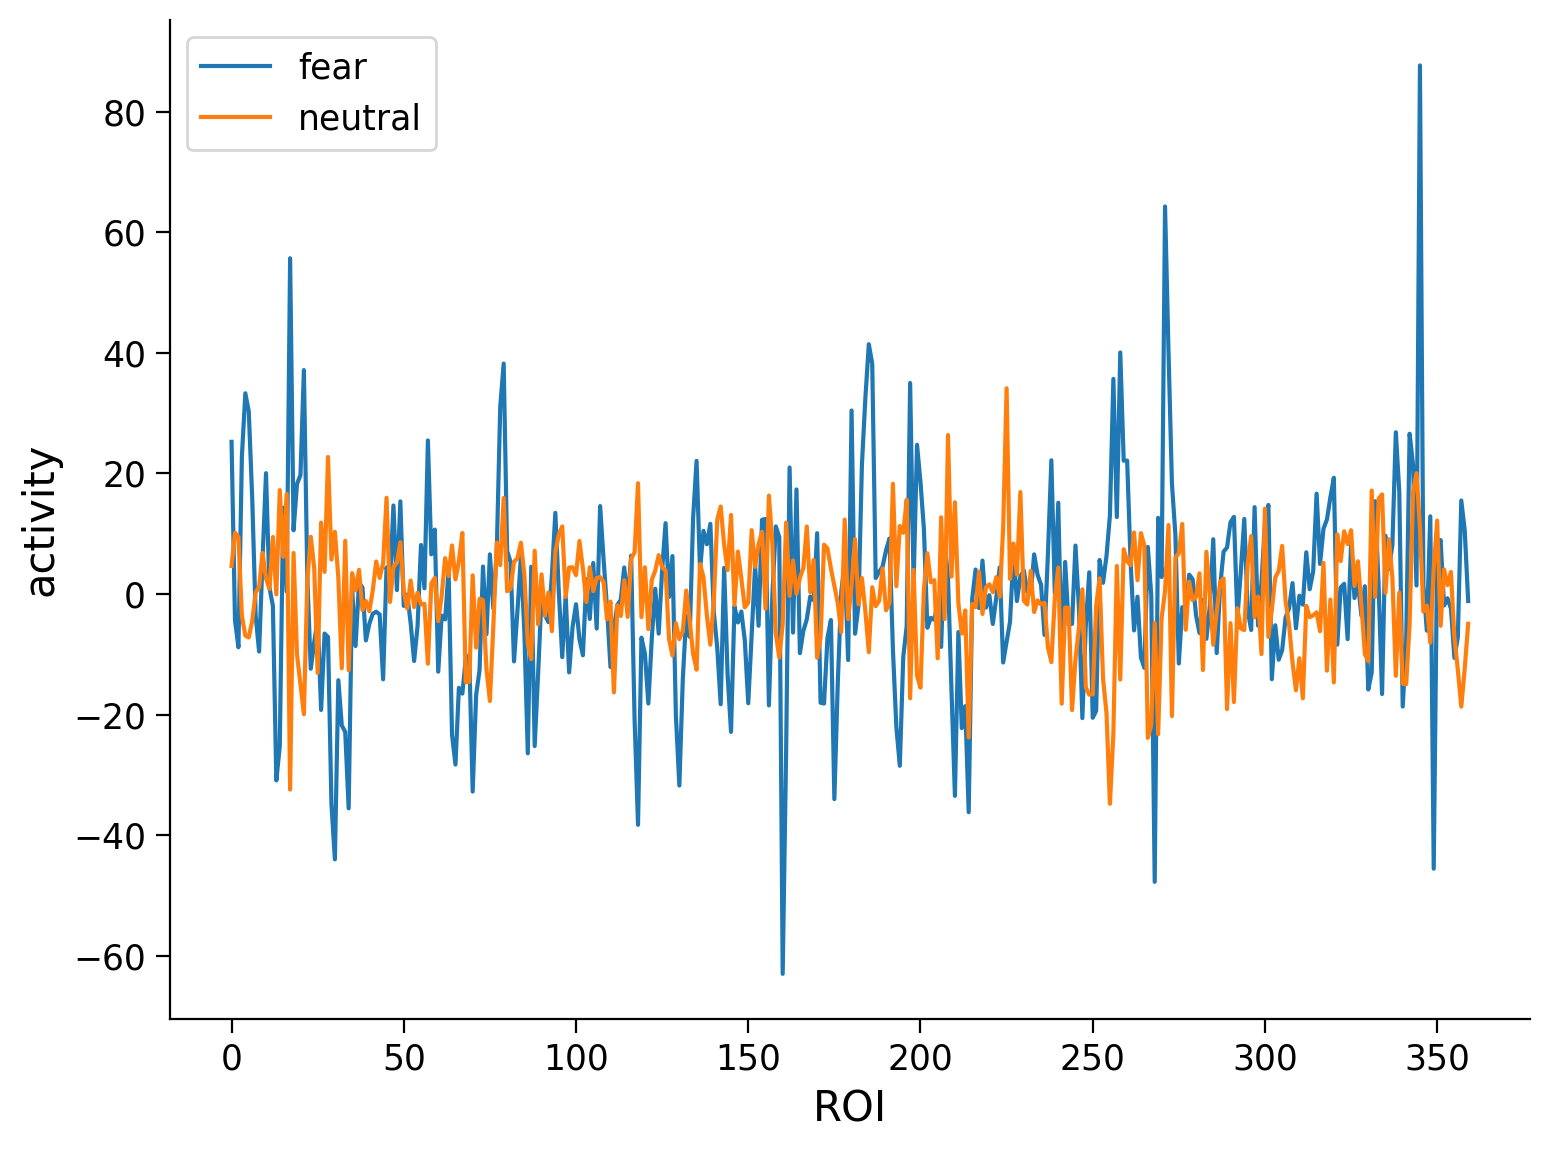

In [ ]:
# Plot activity level in each ROI for both conditions
plt.plot(fear_activity,label='fear')
plt.plot(neut_activity,label='neutral')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

## 📌Data1: Average BOLD activity for individual for each condition and contrast
---

In [ ]:
import numpy as np
arr_1D = np.array([1 ,2, 3, 4, 5, 6, 7, 8])

arr_1D = np.delete(arr_1D, np.where(arr_1D == 8))
print(arr_1D)

[1 2 3 4 5 6 7]


In [ ]:
print(subjects)

['100307' '100408' '101915' '102816' '103414' '103515' '103818' '105115'
 '105216' '106016' '106319' '110411' '111009' '111312' '111514' '111716'
 '113215' '113619' '114924' '115320' '117122' '117324' '118730' '118932'
 '119833' '120111' '120212' '122317' '123117' '124422' '125525' '126325'
 '127933' '128632' '129028' '130013' '130316' '130922' '131924' '133625'
 '133827' '133928' '134324' '135932' '136833' '137128' '138231' '138534'
 '139637' '140824' '142828' '143325' '148032' '148335' '149337' '149539'
 '150524' '151223' '151526' '151627' '153025' '153429' '154431' '156233'
 '156637' '157336' '158035' '158540' '159239' '159340' '160123' '161731'
 '162329' '162733' '163129' '163432' '167743' '172332' '175439' '176542'
 '178950' '182739' '185139' '188347' '189450' '190031' '192439' '192540'
 '193239' '194140' '196144' '196750' '197550' '198451' '199150' '199655'
 '200614' '201111' '201414' '205119']


In [ ]:
print(len(subjects))

100


In [ ]:
exc_subjects = np.delete(subjects,np.where(subjects == '133827'))
exc_subjects = np.delete(exc_subjects,np.where(subjects == '192439'))
print(len(exc_subjects))

98


## 1.1 EMOTION
---

In [ ]:
my_exp = 'EMOTION'
#initialize array for keeping the data
list_indiv_BOLD_fear = []
list_indiv_BOLD_neut = []
list_indiv_contrast_emotion = []
for i_subj in exc_subjects:
  subj_fear = []
  subj_neut = []
  for i_run in [0, 1]:
    data = load_single_timeseries(subject=i_subj, experiment=my_exp,
                                  run=i_run, remove_mean=True)
    evs = load_evs(subject=i_subj, experiment=my_exp,run=i_run)

    #cond: fear
    fear_activity = average_frames(data, evs, my_exp, 'fear')
    subj_fear.append(fear_activity)
    #cond: neutral
    neut_activity = average_frames(data, evs, my_exp, 'neut')
    subj_neut.append(neut_activity)

  #average of 2 runs and append to list_indiv_BOLD
  list_indiv_BOLD_fear.append(np.mean(subj_fear,axis=0))
  list_indiv_BOLD_neut.append(np.mean(subj_neut,axis=0))
  list_indiv_contrast_emotion.append(np.mean(subj_fear,axis=0) - np.mean(subj_neut,axis=0))



###Emotion Network (contrast only)

In [ ]:
#GET Network
my_exp = 'EMOTION'
#initialize array for keeping the data
list_contrast_net_emotion= []

for i_subj in exc_subjects:
  subj_fear = []
  subj_neut = []
  for i_run in [0, 1]:
    data = load_single_timeseries(subject=i_subj, experiment=my_exp,
                                  run=i_run, remove_mean=True)
    evs = load_evs(subject=i_subj, experiment=my_exp,run=i_run)

    #cond: fear
    fear_activity = average_frames(data, evs, my_exp, 'fear')
    subj_fear.append(fear_activity)
    #cond: neutral
    neut_activity = average_frames(data, evs, my_exp, 'neut')
    subj_neut.append(neut_activity)

  #average of 2 runs and append to list_indiv_BOLD
  subj_fear_avg = np.mean(subj_fear,axis=0)
  subj_neut_avg = np.mean(subj_neut,axis=0)

  #Turn 360 regions into 12 networks; do not average over hemisphere so in the end each subj will have 24 features

  #Dataframe for emotion
  df_emotion = pd.DataFrame({'fear_activity' : subj_fear_avg,
                   'neut_activity' : subj_neut_avg,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})
  #fear
  list_fear_net = df_emotion.groupby(["network","hemi" ])["fear_activity"].mean().tolist()

  #neut
  list_neut_net = df_emotion.groupby(["network","hemi" ])["neut_activity"].mean().tolist()
  #contrast net
  list_contrast_net_emotion.append([list_fear_net[i] - list_neut_net[i] for i in range(len(list_neut_net)) ])


In [ ]:
#Check
print(len(list_contrast_net_emotion))
print(len(list_contrast_net_emotion[0]))

98
24


In [ ]:
# df_emotion.groupby(["network","hemi" ])["fear_activity"].mean()

network       hemi 
Auditory      Left     10.081486
              Right    15.384364
Cingulo-Oper  Left      5.887301
              Right     2.643987
Default       Left     13.471703
              Right    10.622781
Dorsal-atten  Left     12.426185
              Right     5.293913
Frontopariet  Left     13.901216
              Right    17.991914
Language      Left      8.173584
              Right    17.617729
Orbito-Affec  Left     16.362953
              Right    13.828290
Posterior-Mu  Left     13.223771
              Right    11.458556
Somatomotor   Left      5.805786
              Right     9.444462
Ventral-Mult  Left     26.618241
              Right    18.130791
Visual1       Left      9.248596
              Right    30.443386
Visual2       Left     17.406913
              Right    23.369150
Name: fear_activity, dtype: float64

## 1.2 SOCIAL task
---

In [ ]:
my_exp = 'SOCIAL'
#initialize array for keeping the data
list_indiv_BOLD_mental = []
list_indiv_BOLD_random = []
list_indiv_contrast_social = []
for i_subj in exc_subjects:
  subj_mental = []
  subj_random = []
  for i_run in [0, 1]:
    data = load_single_timeseries(subject=i_subj, experiment=my_exp,
                                  run=i_run, remove_mean=True)
    evs = load_evs(subject=i_subj, experiment=my_exp,run=i_run)

    #cond: mental
    mental_activity = average_frames(data, evs, my_exp, 'mental')
    subj_mental.append(mental_activity)
    #cond: random
    random_activity = average_frames(data, evs, my_exp, 'rnd')
    subj_random.append(random_activity)

  #average of 2 runs and append to list_indiv_BOLD
  list_indiv_BOLD_mental.append(np.mean(subj_mental,axis=0))
  list_indiv_BOLD_random.append(np.mean(subj_random,axis=0))
  list_indiv_contrast_social.append(np.mean(subj_mental,axis=0) - np.mean(subj_random,axis=0))


###Social Network (contrast only)

In [ ]:

#GET Network
my_exp = 'SOCIAL'
#initialize array for keeping the data
list_contrast_net_social= []
for i_subj in exc_subjects:
  subj_mental = []
  subj_random = []
  for i_run in [0, 1]:
    data = load_single_timeseries(subject=i_subj, experiment=my_exp,
                                  run=i_run, remove_mean=True)
    evs = load_evs(subject=i_subj, experiment=my_exp,run=i_run)

    #cond: mental
    mental_activity = average_frames(data, evs, my_exp, 'mental')
    subj_mental.append(mental_activity)
    #cond: random
    random_activity = average_frames(data, evs, my_exp, 'rnd')
    subj_random.append(random_activity)

  #average of 2 runs and append to list_indiv_BOLD
  subj_mental_avg = np.mean(subj_mental,axis=0)
  subj_random_avg = np.mean(subj_random,axis=0)

  #Turn 360 regions into 12 networks; do not average over hemisphere so in the end each subj will have 24 features

  #Dataframe for emotion
  df_social = pd.DataFrame({'mental_activity' : subj_mental_avg,
                   'random_activity' : subj_random_avg,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})
  #mental
  list_mental_net = df_social.groupby(["network","hemi" ])["mental_activity"].mean().tolist()

  #random
  list_random_net = df_social.groupby(["network","hemi" ])["random_activity"].mean().tolist()
  #contrast net
  list_contrast_net_social.append([list_mental_net[i] - list_random_net[i] for i in range(len(list_random_net)) ])


In [ ]:
#Check
print(len(list_contrast_net_social))
print(len(list_contrast_net_social[0]))

98
24


## 1.3 GAMBLING task
---

In [ ]:
my_exp = 'GAMBLING'
#initialize array for keeping the data
list_indiv_BOLD_win = []
list_indiv_BOLD_loss = []
list_indiv_contrast_gambling = []
for i_subj in exc_subjects:
  subj_win = []
  subj_loss = []
  for i_run in [0, 1]:
    data = load_single_timeseries(subject=i_subj, experiment=my_exp,
                                  run=i_run, remove_mean=True)
    evs = load_evs(subject=i_subj, experiment=my_exp,run=i_run)

    #cond: mental
    win_activity = average_frames(data, evs, my_exp, 'win')
    subj_win.append(win_activity)
    #cond: random
    loss_activity = average_frames(data, evs, my_exp, 'loss')
    subj_loss.append(loss_activity)

  #average of 2 runs and append to list_indiv_BOLD
  list_indiv_BOLD_win.append(np.mean(subj_win,axis=0))
  list_indiv_BOLD_loss.append(np.mean(subj_loss,axis=0))
  list_indiv_contrast_gambling.append(np.mean(subj_win,axis=0) - np.mean(subj_loss,axis=0))

###Gambling Network (contrast only)

In [ ]:

#GET Network
my_exp = 'GAMBLING'
#initialize array for keeping the data
list_contrast_net_gambling= []
for i_subj in exc_subjects:
  subj_win = []
  subj_loss = []
  for i_run in [0, 1]:
    data = load_single_timeseries(subject=i_subj, experiment=my_exp,
                                  run=i_run, remove_mean=True)
    evs = load_evs(subject=i_subj, experiment=my_exp,run=i_run)

    #cond: mental
    win_activity = average_frames(data, evs, my_exp, 'win')
    subj_win.append(win_activity)
    #cond: random
    loss_activity = average_frames(data, evs, my_exp, 'loss')
    subj_loss.append(loss_activity)

  #average of 2 runs and append to list_indiv_BOLD
  subj_win_avg = np.mean(subj_win,axis=0)
  subj_loss_avg = np.mean(subj_loss,axis=0)

  #Turn 360 regions into 12 networks; do not average over hemisphere so in the end each subj will have 24 features

  #Dataframe for emotion
  df_gambling = pd.DataFrame({'win_activity' : subj_win_avg,
                   'loss_activity' : subj_loss_avg,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})
  #win
  list_win_net = df_gambling.groupby(["network","hemi" ])["win_activity"].mean().tolist()

  #loss
  list_loss_net = df_gambling.groupby(["network","hemi" ])["loss_activity"].mean().tolist()
  #contrast net
  list_contrast_net_gambling.append([list_win_net[i] - list_loss_net[i] for i in range(len(list_win_net)) ])

In [ ]:
#Check
print(len(list_contrast_net_gambling))
print(len(list_contrast_net_gambling[0]))

98
24


## Writing csv files
---

In [ ]:
#network columns

network_columns = ['Auditory_L','Auditory_R','Cingulo-Oper_L','Cingulo-Oper_R','Default_L','Default_R', 'Dorsal-atten_L','Dorsal-atten_R', 'Frontopariet_L', 'Frontopariet_R', 'Language_L', 'Language_R' , 'Orbito-Affec_L', 'Orbito-Affec_R', 'Posterior-Mu_L', 'Posterior-Mu_R', 'Somatomotor_L', 'Somatomotor_R', 'Ventral-Mult_L', 'Ventral-Mult_R', 'Visual1_L', 'Visual1_R', 'Visual2_L', 'Visual2_L']

In [ ]:
#get col name
# let's assume these lists have been populated with the relevant sections


list_task = ['Emotion','Social','Gambling']


for i in range(len(network_columns)):
    col_emotion = [list_task[0]+'_'+area for area in network_columns]

for i in range(len(network_columns)):
    col_social = [list_task[1]+'_'+area for area in network_columns]

for i in range(len(network_columns)):
    col_gambling = [list_task[2]+'_'+area for area in network_columns]

#check
print(col_emotion)
print(col_social)
print(col_gambling)

list_columns_net = ['subject_id'] + col_emotion + col_social + col_gambling
print(len(list_columns_net) == 24*3+1)

['Emotion_Auditory_L', 'Emotion_Auditory_R', 'Emotion_Cingulo-Oper_L', 'Emotion_Cingulo-Oper_R', 'Emotion_Default_L', 'Emotion_Default_R', 'Emotion_Dorsal-atten_L', 'Emotion_Dorsal-atten_R', 'Emotion_Frontopariet_L', 'Emotion_Frontopariet_R', 'Emotion_Language_L', 'Emotion_Language_R', 'Emotion_Orbito-Affec_L', 'Emotion_Orbito-Affec_R', 'Emotion_Posterior-Mu_L', 'Emotion_Posterior-Mu_R', 'Emotion_Somatomotor_L', 'Emotion_Somatomotor_R', 'Emotion_Ventral-Mult_L', 'Emotion_Ventral-Mult_R', 'Emotion_Visual1_L', 'Emotion_Visual1_R', 'Emotion_Visual2_L', 'Emotion_Visual2_L']
['Social_Auditory_L', 'Social_Auditory_R', 'Social_Cingulo-Oper_L', 'Social_Cingulo-Oper_R', 'Social_Default_L', 'Social_Default_R', 'Social_Dorsal-atten_L', 'Social_Dorsal-atten_R', 'Social_Frontopariet_L', 'Social_Frontopariet_R', 'Social_Language_L', 'Social_Language_R', 'Social_Orbito-Affec_L', 'Social_Orbito-Affec_R', 'Social_Posterior-Mu_L', 'Social_Posterior-Mu_R', 'Social_Somatomotor_L', 'Social_Somatomotor_R', 

In [ ]:
import csv
import pandas as pd


list_all_data = []

for row_idx in range(len(list_contrast_net_emotion)):
    row = []
    row.append(exc_subjects[row_idx])
    row.extend(list_contrast_net_emotion[row_idx])
    row.extend(list_contrast_net_social[row_idx])
    row.extend(list_contrast_net_gambling[row_idx])

    list_all_data.append(row)


df_BOLD = pd.DataFrame(list_all_data,columns=list_columns_net)
print(df_BOLD)
df_BOLD.to_csv('BOLD_contrast_network_98.csv', index=False)


   subject_id  Emotion_Auditory_L  Emotion_Auditory_R  Emotion_Cingulo-Oper_L  \
0      100307           -2.804921           -2.433804               -0.777985   
1      100408            3.516186            7.529671               -9.521039   
2      101915            9.980518            5.266869                9.546204   
3      102816           20.833271          -16.487274                1.886792   
4      103414            9.885700            5.633930                9.734162   
..        ...                 ...                 ...                     ...   
93     199655           -3.796242           -3.248363              -12.931731   
94     200614           -2.340933           -0.460370               -6.904875   
95     201111           -0.313696           -3.006372                7.014663   
96     201414            9.047621            3.032789               -4.672088   
97     205119           18.881525           12.401503                7.964594   

    Emotion_Cingulo-Oper_R 

### Columns for 360 areas
---

In [ ]:
#get col name
# let's assume these lists have been populated with the relevant sections
list_columns = []
list_columns.append("subject_id")

for i in range(360):
    list_columns.append(f"BOLD_fear_{i+1}")

for i in range(360):
    list_columns.append(f"BOLD_neut_{i+1}")

for i in range(360):
    list_columns.append(f"contrast_emotion_{i+1}")

for i in range(360):
    list_columns.append(f"BOLD_mental_{i+1}")

for i in range(360):
    list_columns.append(f"BOLD_random_{i+1}")

for i in range(360):
    list_columns.append(f"contrast_social_{i+1}")

for i in range(360):
    list_columns.append(f"BOLD_win_{i+1}")

for i in range(360):
    list_columns.append(f"BOLD_loss_{i+1}")

for i in range(360):
    list_columns.append(f"contrast_gambling_{i+1}")
print(len(list_columns) == 360*9 +1)

True


In [ ]:
import csv
import pandas as pd


list_all_data = []
for row_idx in range(len(list_indiv_BOLD_fear)):
    row = []
    row.append(exc_subjects[row_idx])
    row.extend(list_indiv_BOLD_fear[row_idx])
    row.extend(list_indiv_BOLD_neut[row_idx])
    row.extend(list_indiv_contrast_emotion[row_idx])
    row.extend(list_indiv_BOLD_mental[row_idx])
    row.extend(list_indiv_BOLD_random[row_idx])
    row.extend(list_indiv_contrast_social[row_idx])
    row.extend(list_indiv_BOLD_win[row_idx])
    row.extend(list_indiv_BOLD_loss[row_idx])
    row.extend(list_indiv_contrast_gambling[row_idx])
    list_all_data.append(row)


df_BOLD = pd.DataFrame(list_all_data,columns=list_columns)
df_BOLD.to_csv('BOLD_98_individual.csv', index=False)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## SOCIAL Task
---

In [ ]:
#SOCIAL task average frame calculate
my_exp = 'SOCIAL'
my_subj = subjects[0]
my_run = 1
#use load_single_timeseries
data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
#use load_evs
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)
#use average frame
rand_activity = average_frames(data, evs, my_exp, 'rnd')
mental_activity = average_frames(data,evs, my_exp, 'mental')

In [ ]:
# SOCIAL: Plot activity level in each ROI for both conditions
plt.plot(rand_activity,label='random')
plt.plot(mental_activity,label='mental')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

## GAMBLING task
---

In [ ]:
#GAMBLING task average frame calculate
my_exp = 'GAMBLING'
my_subj = subjects[0]
my_run = 1
#use load_single_timeseries
data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
#use load_evs
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)
#use average frame
win_activity = average_frames(data, evs, my_exp, 'win')
loss_activity = average_frames(data,evs, my_exp, 'loss')


# GAMBLING: Plot activity level in each ROI for both conditions
plt.plot(win_activity,label='win')
plt.plot(loss_activity,label='loss')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

### Try plotting the "average frame" data of ALL subjects

In [ ]:
# try plotting Brain activity for each tasks

# Gambling
my_exp = 'GAMBLING'


subj_no = 1
for cond in EXPERIMENTS[my_exp]['cond']:
  list_activity = [] # initializing the list_ activity
  for subj_i in range(len(subjects)):
    my_subj = subjects[subj_i]
    my_run = 1
    data = load_single_timeseries(subject=my_subj,
                            experiment=my_exp,
                            run=my_run,
                            remove_mean=True)
    evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)
    gambling_activity = average_frames(data,evs,my_exp,cond)
    # Plot activity level in each ROI for both conditions
    list_activity.append(gambling_activity)

    subj_no += 1
  plt.plot(list_activity)
  plt.xlabel('ROI')
  plt.ylabel('activity')
  plt.legend()
  plt.title(cond)
  plt.show()


In [ ]:
# try plotting Brain activity for each tasks

#
my_exp = 'SOCIAL'


subj_no = 1
for cond in EXPERIMENTS[my_exp]['cond']:
  list_activity = [] # initializing the list_ activity
  for subj_i in range(len(subjects)):
    my_subj = subjects[subj_i]
    my_run = 1
    data = load_single_timeseries(subject=my_subj,
                            experiment=my_exp,
                            run=my_run,
                            remove_mean=True)
    evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)
    gambling_activity = average_frames(data,evs,my_exp,cond)
    # Plot activity level in each ROI for both conditions
    list_activity.append(gambling_activity)

    subj_no += 1
  plt.plot(list_activity)
  plt.xlabel('ROI')
  plt.ylabel('activity')
  plt.legend()
  plt.title(cond)
  plt.show()

  # plot according to the network

  avg_activity = np.mean(list_activity)

  print('average',avg_activity)
  # plt.plot(avg_activity)
  # plt.xlabel('ROI')
  # plt.ylabel('activity')
  # plt.legend()
  # plt.title('average')
  # plt.show()
  # df = pd.DataFrame({'neutral_activity' : avg_activity,
  #                  'network' : region_info['network'],
  #                  'hemi' : region_info['hemi']})

  # sns.barplot(y='network', x='neutral_activity', data=df, hue='hemi')
  # plt.show()

In [ ]:
#try running through all the data and subjects to check if all the data can be accessed

subj_no = 1
for subj_i in range(len(subjects)):
  for experiment, conds in EXPERIMENTS.items():
    for cond in conds['cond']:
      my_exp = experiment
      my_subj = subjects[subj_i]
      my_run = 1
      data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
      evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)
      try:
        average_frames(data,evs,my_exp,cond)
      except:
        print('error: ', str(subj_i), experiment, cond)

  subj_no += 1



## Contrast and network
---

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





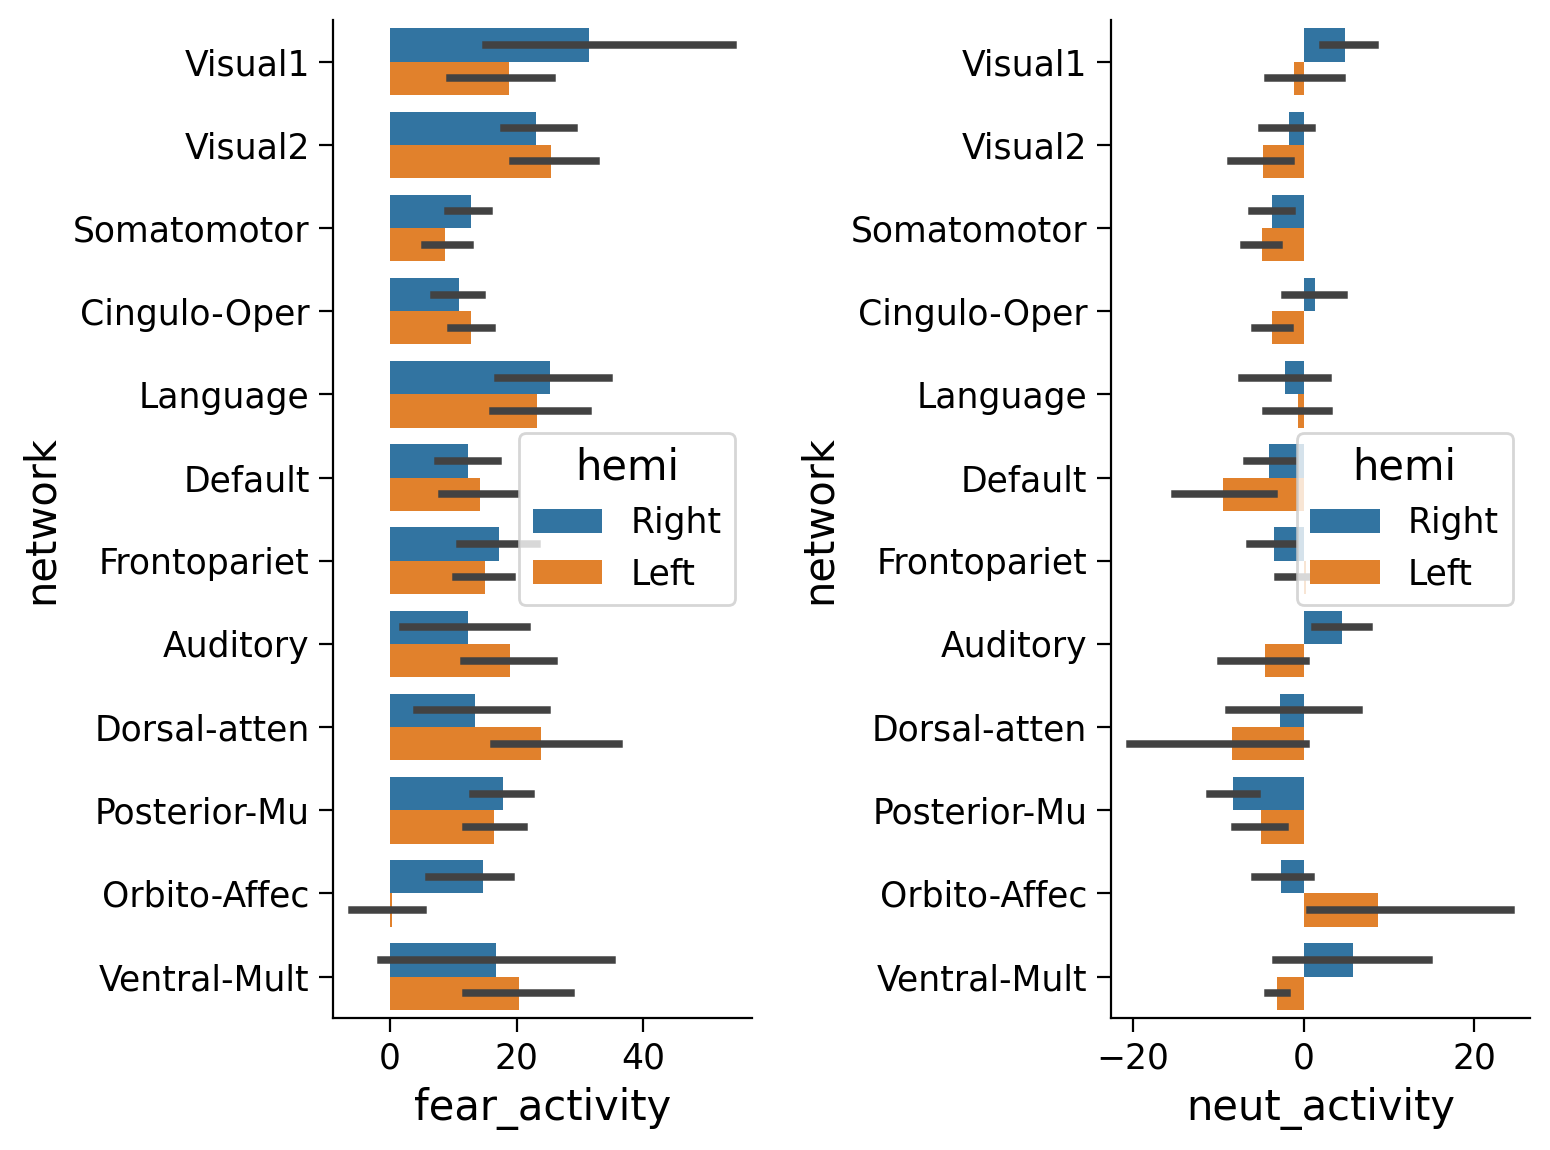

In [ ]:
#EMOTION task
df = pd.DataFrame({'fear_activity' : fear_activity,
                   'neut_activity' : neut_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='fear_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='neut_activity', data=df, hue='hemi',ax=ax2)
plt.show()

In [ ]:
#SOCIAL task
df = pd.DataFrame({'mental_activity' : mental_activity,
                   'rand_activity' : rand_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})
print(df)

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='mental_activity', data=df, hue='hemi',ax=ax1) #sns barplot prob. show only 10 first regions
sns.barplot(y='network', x='rand_activity', data=df, hue='hemi',ax=ax2)
plt.show()

You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be subtle at the single subject/session level (these are quick 3-4min scans).


Let us boost thee stats by averaging across all subjects and runs.

## Average across all subjects and runs
---

#EMOTION task

In [ ]:
#EMOTION
my_exp = 'EMOTION' #'SOCIAL' , 'GAMBLING'

In [ ]:
group_contrast_emotion = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    fear_activity = average_frames(data, evs, my_exp, 'fear')
    neut_activity = average_frames(data, evs, my_exp, 'neut')

    contrast = fear_activity - neut_activity
    group_contrast_emotion += contrast

group_contrast_emotion /= (len(subjects)*2)  # remember: 2 sessions per subject

In [ ]:
df = pd.DataFrame({'contrast' : group_contrast_emotion,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']
                   })
# we will plot the fear foot minus neutral foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.title('group contrast of fear vs neutral')
plt.show()

## Visualising the results on a brain
---

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [ ]:
# @title NMA provides an atlas. Run this cell to download it
import os, requests

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

In [ ]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast_emotion[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)

### Group contrast for Social and Gambling respectively
---

In [ ]:
#SOCIAL

my_exp = 'SOCIAL'
#calculate group contrast SOCIAL
group_contrast_social = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    mental_activity = average_frames(data, evs, my_exp, 'mental')
    rnd_activity = average_frames(data, evs, my_exp, 'rnd')

    contrast = mental_activity - rnd_activity
    group_contrast_social += contrast

group_contrast_social /= (len(subjects)*2)  # remember: 2 sessions per subject



#Plot contrast bar graph SOCIAL
df = pd.DataFrame({'contrast' : group_contrast_social,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']
                   })
# we will plot the fear foot minus neutral foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.title('group contrast of mental vs random')
plt.show()


#PLot the on atlas SOCIAL
# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast_social[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)


In [ ]:
#try: fsaverage['infl_right'], Labels_R
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast_social[atlas["labels_R"]]
plotting.view_surf(fsaverage['infl_right'],
                   surf_contrast,
                   vmax=20)

## GAMBLING
---


In [ ]:
#GAMBLING

my_exp = 'GAMBLING'
#calculate group contrast GAMBLING
group_contrast_gambling = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    win_activity = average_frames(data, evs, my_exp, 'win')
    loss_activity = average_frames(data, evs, my_exp, 'loss')

    contrast = win_activity - loss_activity
    group_contrast_gambling += contrast

group_contrast_gambling /= (len(subjects)*2)  # remember: 2 sessions per subject



#Plot contrast bar graph GAMBLING
df = pd.DataFrame({'contrast' : group_contrast_gambling,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']
                   })
# we will plot the fear foot minus neutral foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.title('group contrast of win vs loss')
plt.show()


#PLot the on atlas SOCIAL
# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast_gambling[atlas["labels_L"]]

plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)


### Archived Codes
---

In [ ]:
def average_frames_modi(data, evs, experiment, cond):

  idx = EXPERIMENTS[experiment]['cond'].index(cond) #the index of condition ex. 'fear' = 0, 'neut = 1' this depends on the position of that condition in dict EXPERIMENT
  list_of_mean = []
  for i in range(len(evs[idx])-1):
    print("len(data[:, evs[idx][i]])",len(data[:, evs[idx][i]]))
    print("evs[idx][i]",evs[idx][i])
    print("data[:, evs[idx][i]]", data[:, evs[idx][i]])

    list_of_mean.append(np.mean(data[:, evs[idx][i]], axis=1, keepdims=True))
  print("len(list_of_mean)",len(list_of_mean)) # ==> the list of mean is a list(2) of lists (360); this is the same as the result of list comprehension below
  print("len(list_of_mean[0])",len(list_of_mean[0]))
            #print("list_of_mean",list_of_mean)
  np.concatenate(list_of_mean,axis=-1)
  print("len(np.concatenate(list_of_mean,axis=-1))",len(np.concatenate(list_of_mean,axis=-1)))
  print("np.concatenate(list_of_mean,axis=-1)",np.concatenate(list_of_mean,axis=-1))
  print("len(np.mean(np.concatenate(list_of_mean), axis=1))",len(np.mean(np.concatenate(list_of_mean), axis=1)))
  print("np.mean(np.concatenate(list_of_mean), axis=1)",np.mean(np.concatenate(list_of_mean), axis=1))
  return np.mean(np.concatenate(list_of_mean), axis=1)